***Welcome to Medical image processing in Python***<br/>

Presented by: Reza Saadatyar (2024-2025) <br/>
E-mail: Reza.Saadatyar@outlook.com 

**Import the require library**

In [1]:
import sys
import numpy as np
from tqdm import tqdm
from PIL import Image
from Functions import Data_path
import matplotlib.pyplot as plt
from skimage import io
# from skimage.viewer import ImageViewer
# from OOP import Pre_Processing_R2g
# from Functions import image_resizer

**1. Set Image Path & Load data**

In [2]:
folder_path = "D:/Medical-Image-Processing/Data/Inputs/"
files_inputs, _, _ = Data_path.data_path(folder_path, data_format="tif")

folder_path = "D:/Medical-Image-Processing/Data/Masks/"
files_masks, _, _ = Data_path.data_path(folder_path, data_format="TIF")

*Image-Width: n*<br/>
*Image-Height: m*<br/>
*Channels: c*<br/>
*Planes: p*<br/>
*Grayscale: (p, m, n)*<br/>
*RGB: (p, m, n, c)*<br/>

In [3]:
data = io.imread(files_inputs[0])   # Load a file for obtaing size data
img_height = data.shape[0]
img_width = data.shape[1]
img_channels = data.shape[2]
inputs = np.zeros((len(files_inputs), img_height, img_width, img_channels), dtype = np.uint8) # 58*768*896*3
labels = np.zeros((len(files_inputs), img_height, img_width, 2), dtype = bool)                    # 58*768*896*2

In [4]:
sys.stdout.flush()
for ind, _ in tqdm(enumerate(files_inputs)):
    inputs[ind] = io.imread(files_inputs[ind])[:, :, :3]
    mask = np.squeeze(io.imread(files_masks[ind])).astype(bool)
    labels[ind, :, :, 0] = ~mask
    labels[ind, :, :, 1] = mask

0it [00:00, ?it/s]

58it [00:01, 50.46it/s]


**[Image Resizing](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize)**<br/>
`Standardizing Image Dimensions:` Machine learning models, like CNNs, need input data with fixed dimensions. For instance, if a model requires images of size 224x224x3, all input images must be resized to that shape.<br/>
`Reducing Computational Load:`Resizing images to smaller dimensions lowers computational costs, particularly with large datasets, and aids in faster training or inference for deep learning models.

In [125]:
# Create the resizer instance
resizer = image_resizer.ImageResizer(img_height_resized=255, img_width_resized=255, img_channels=3)

# Resizing the images
resized_images = resizer.resize_images(inputs)
print(f"Resizing images from {inputs.shape} to {resized_images.shape}") 

Resizing images from (58, 768, 896, 3) to (58, 255, 255, 3)


**Augmentation, Re_Color, & Im_Saving**<br/>

In [15]:
import os
import glob
import shutil
import numpy as np
from skimage import transform, color  
from tensorflow import keras

#  ================================= Class for resizing & converting images ====================================
class Image:
    def __init__(self, img_data: np.ndarray):
        """
        :param imgs: A numpy array of shape [num_images, height, width, channels].
        """
        self.img_data = img_data
        
    # ---------------------------------------------- Resizes ---------------------------------------------------
    def resize_images(self, img_height_resized: int, img_width_resized: int, img_channels: int) -> np.ndarray:
        """
        Resizes a batch of images to the specified height, width, and channels.

        
        :return: A numpy array of resized images.
        """
        # Initialize an empty array to store resized images
        resized_imgs = np.zeros(
            (self.img_data.shape[0], img_height_resized, img_width_resized, img_channels),
            dtype=np.uint8
        )
        
        # Loop through each image in the batch
        for i in range(self.img_data.shape[0]):
            # Resize the image to the target dimensions and store it
            resized_imgs[i] = transform.resize(
                self.img_data[i],
                (img_height_resized, img_width_resized, img_channels),
                preserve_range=True  # Preserve the range of pixel values
            )
            
        return resized_imgs  # Return the resized images
    
    # ------------------------------------------ RGB images to grayscale ---------------------------------------
    def rgb2gray_scale(self) -> np.ndarray:
        """
        Converts the RGB images to grayscale.

        :return: A numpy array of grayscale images.
        """

        img_num, img_height, img_width, _ = self.img_data.shape
        img_gray = np.zeros((img_num, img_height, img_width), dtype=np.uint8)

        for i in range(img_num):
            # img_gray[i] = (color.rgb2gray(self.img_data[i]) * 255).astype(np.uint8)  # scale back to [0, 255]

            img_gray[i] = color.rgb2gray(self.img_data[i])
        
        return img_gray


# ================================== Class for augmentation (rotation) =========================================
class Augmentation:
    def __init__(self, num_augmented_imag: int, imag_files_path: str, imag_augmented_path: str):
        """
        Applies image augmentation (rotation) to images in the specified directory and saves them.

        :param num_augmented_images: Number of augmented images to generate.
        :param imag_files_path: Path to the directory containing the images.
        :param imag_augmented_path: Path to the directory to save augmented images.
        """
        
        self.imag_files_path = imag_files_path
        self.num_augmented_imag = num_augmented_imag
        self.imag_augmented_path = imag_augmented_path

        
    def augmented_images(self) -> None:
        
        dat = io.imread(glob.glob(self.imag_files_path + '/*')[0])
        print(f"{dat.shape = }")
        imag_augmented_path = os.path.join(imag_augmented_path, 'Rotated/')
        os.makedirs(imag_augmented_path, exist_ok=True)  # Ensure the temporary folder is created
        # Create a temporary folder inside the original folder for processing
        TEMP_DIR = os.path.join(self.imag_files_path, 'Temp/')
        os.makedirs(TEMP_DIR, exist_ok=True)  # Ensure the temporary folder is created
        
        # Copy all files from the main folder to the temporary folder
        for filename in os.listdir(self.imag_files_path):
            if filename.lower().endswith(('.tif', '.jpg', '.png')):  # Correct usage with a tuple
                shutil.copy(os.path.join(self.imag_files_path, filename), os.path.join(TEMP_DIR, filename))
   
        # Set up the ImageDataGenerator for image augmentation
        Data_Gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=30)  # Rotate images randomly up to 30 degrees
        # Use flow_from_directory to process the images in the Temp folder
        img_aug = Data_Gen.flow_from_directory(
            self.imag_files_path,     # Parent directory of Temp
            classes=['Temp'],    # Specify the subfolder 'Temp' as the target
            batch_size=1,        # Process one image at a time
            save_to_dir=imag_augmented_path,  # Save augmented images to the Rotated folder
            save_prefix='Aug',   # Prefix for augmented images
            target_size=(dat.shape[1], dat.shape[2]),  # Resize images to the specified dimensions
            class_mode=None      # No labels, as we're working with unclassified images
        )
        
        for _ in range(self.num_augmented_imag):  # Generate augmented images and save them
            next(img_aug)  # Process the next image and save it

        shutil.rmtree(TEMP_DIR)  # Delete the temporary folder and its contents after processing

    # ---------------------------------------------- Plot ------------------------------------------------------
    def plot_img_original_augment(self, num_img: int) -> None:
        
        _, axs = plt.subplots(nrows=2, ncols=num_img)
        
        # Check if num_img is 1 (special case for 1 image)
        if num_img == 1:
            # Display images on the first row
            # io.imread(files_inputs[0])[:, :, :3].shape
            axs[0].imshow(io.imread(glob.glob(self.imag_files_path + '/*')[0]), cmap='gray')
            axs[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
            [spine.set_visible(False) for spine in axs[0].spines.values()]  # Hide all spines
            axs[0].set_ylabel("Original Images", fontsize=12, labelpad=10)  # Y-axis label for the first row
            
            # Display images on the second row
            axs[1].imshow(io.imread(glob.glob(self.imag_augmented_path + '/*')[0]), cmap='gray')
            axs[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
            [spine.set_visible(False) for spine in axs[1].spines.values()]  # Hide all spines
            axs[1].set_ylabel("Augmented Images", fontsize=12, labelpad=10)  # Y-axis label for the second row

        else:
            for i in range(num_img):
                # Display images on the first row
                axs[0, i].imshow(io.imread(glob.glob(self.imag_files_path + '/*')[i]), cmap='gray')
                axs[0, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
                [spine.set_visible(False) for spine in axs[0, i].spines.values()]  # Hide all spines

                # Display images on the second row
                axs[1, i].imshow(io.imread(glob.glob(self.imag_augmented_path + '/*')[i]), cmap='gray')
                axs[1, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
                [spine.set_visible(False) for spine in axs[1, i].spines.values()]  # Hide all spines

            # Add ylabel for each row (only set ylabel for the first column of each row)
            axs[0, 0].set_ylabel("Original Images", fontsize=12, labelpad=10)  # Y-axis label for the first row
            axs[1, 0].set_ylabel("Augmented Images", fontsize=12, labelpad=10)  # Y-axis label for the second row

        # Adjust layout to make sure images and titles don't overlap
        plt.tight_layout()

        # Auto-scale to fit the images in the figure area
        plt.autoscale(enable=True, axis='both', tight=True)
        plt.show()

img = Image(inputs)

In [ ]:
# Resizing the images
resized_images = img.resize_images(img_height_resized=255, img_width_resized=255, img_channels=3)
print(f"Resizing images from {inputs.shape} to {resized_images.shape}") 

Resizing images from (58, 768, 896, 3) to (58, 255, 255, 3)


In [ ]:
a = img.rgb2gray_scale()
a.shape

In [14]:
a.shape

(58, 768, 896)

In [ ]:

resized_images = resizer.resize_images(img_height_resized=255, img_width_resized=255, img_channels=3)
print(f"Resizing images from {inputs.shape} to {resized_images.shape}") 

Resizing images from (58, 768, 896, 3) to (58, 255, 255, 3)


In [6]:
num_augmented_imag = 3
# Path to the folder containing the original images
imag_files_path = 'D:/Medical-Image-Processing/Data/Masks/'

# Path where augmented images will be saved
imag_augmented_path = 'D:/Medical-Image-Processing/Data/'

resizer.augmented_images(num_augmented_imag, imag_files_path, imag_augmented_path)

AttributeError: 'Image' object has no attribute 'augmented_images'

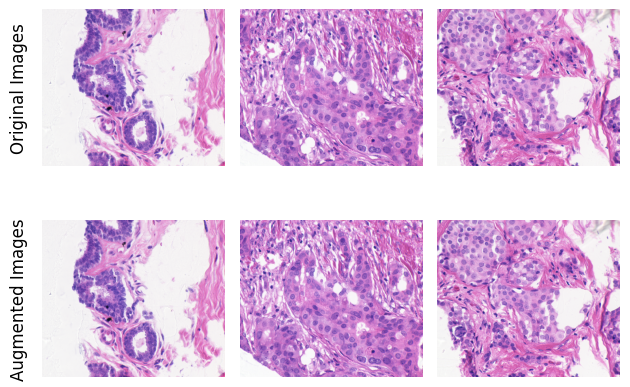

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


num_img = 3  # Number of images to display (change this to 1 or more)

fig, axs = plt.subplots(nrows=2, ncols=num_img)

# Check if num_img is 1 (special case for 1 image)
if num_img == 1:
    # Display images on the first row
    axs[0].imshow(inputs[1], cmap='gray')
    axs[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
    [spine.set_visible(False) for spine in axs[0].spines.values()]  # Hide all spines
    axs[0].set_ylabel("Original Images", fontsize=12, labelpad=10)  # Y-axis label for the first row
    
    # Display images on the second row
    axs[1].imshow(inputs[1], cmap='gray')
    axs[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
    [spine.set_visible(False) for spine in axs[1].spines.values()]  # Hide all spines
    axs[1].set_ylabel("Augmented Images", fontsize=12, labelpad=10)  # Y-axis label for the second row

else:
    for i in range(num_img):
        # Display images on the first row
        axs[0, i].imshow(inputs[i], cmap='gray')
        axs[0, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
        [spine.set_visible(False) for spine in axs[0, i].spines.values()]  # Hide all spines

        # Display images on the second row
        axs[1, i].imshow(inputs[i], cmap='gray')
        axs[1, i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Hide ticks
        [spine.set_visible(False) for spine in axs[1, i].spines.values()]  # Hide all spines

    # Add ylabel for each row (only set ylabel for the first column of each row)
    axs[0, 0].set_ylabel("Original Images", fontsize=12, labelpad=10)  # Y-axis label for the first row
    axs[1, 0].set_ylabel("Augmented Images", fontsize=12, labelpad=10)  # Y-axis label for the second row

# Adjust layout to make sure images and titles don't overlap
plt.tight_layout()

# Auto-scale to fit the images in the figure area
plt.autoscale(enable=True, axis='both', tight=True)
plt.show()


In [27]:
inputs[0].shape

(768, 896, 3)